# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

### Name & PID

- Name: Carlos Eduardo Matos Ribeiro
- PID: A14032489

# Research Question

Does the location of a restaurant in North Carolina impact its overall sanitary conditions? Is such impact caused by the socioeconomic conditions of a restaurant's neighborhood?

Possible ideas:
- Investigate the connection between neighborhood income and average restaruant "cleaniness"?
- Check number of inspections per zip code and check factors impacting number of inspections (average score of restaurants in the same area, average income of related zip-code)
- Investigate factors that will impact the score of a restaurant (average income of zip-code, result of previous inspections, result of neighboring (how to define? latitude and logitude?) restaurants)


## Background and Prior Work

In North Carolina, restaurants and other food establishments are inspected by local county professionals between one and four times annually$^{1}$. In these inspections, violations are counted and tabulated, each with its own point value depending on its severity; the points are then subtracted from 100 to give a restaurant's final score, which is then used to determine its letter grade$^{1}$. This simple system allows for a straightforward way to quantify the sanitary conditions of restaurants, making it possible to carry out data analyses to investigate general trends and determining factors of said conditions.

With that in mind, I have decided to investgiate whether the location of a restaurant in North Carolina, and more specifically said location's socio-economic condition, has a considerable impact in said restaurant's sanitary conditions. Certain characteristics about neighborhoods, including how busy it is and the average spending potential of its residents/bypassers, can greatly impact key factors for a restaurant's success, including the amount of customers it can expect to have and the amount of revenue that it can generate. Customer traffic and revenue in turn can affect many factors related to sanitary conditions, including: how much staff a restaurant can hire (and how overworked said staff is), how well trained the staff is, the quality of the equipment, the quality of the produce, how often produce has to be restocked, how  much attention managers can devote to health and safety practices, etc. Therefore, it is reasonable to expect that the socio-economic conditions of a restaurant's area will somehow affect its health and safety conditions.

The most relevant research related to my investigation was a study conducted by the Environmental Health Specialists Network, based on several US states, which aimed to identify which factors most impacted safe food preparation practices in a restaurant. The study concluded that some of the main factors were the time pressure the employees felt, the quality of their equipment, the resources they had available and the emphasis managers gave to food safety$^{2}$. As discussed in the previous paragraph, many of these factors can be impacted by a restaurant's location and its socio-economic conditions, so this study helps corroborate that my research question holds promise and is worth investigating.


References (include links):
- 1) https://www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx
- 2)https://www.cdc.gov/nceh/ehs/ehsnet/docs/Factors_Impacting_Food_Workers_Food_Prep_FPT_journal.pdf


Possible sources:
- http://data-wake.opendata.arcgis.com/datasets/food-inspections
- https://www.wral.com/yuck-or-yum-inspection-grades-keep-restaurants-diners-safe/16548733/
- https://www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx (official article with some description of inspections)
- https://www.starnewsonline.com/news/20190823/on-restaurant-inspections-new-hanover-fights-uphill-battle (article about county in North Carolina falling behind on inspections 

# Hypothesis


I expect that there will be a postive relationship between North Carolina restaurants' location and the socio-economic characteristics of said location, and their overall sanitary conditions, with restaurants in wealthier neighborhoods having fewer health/safety violations then restaurants in low-income, emptier neighborhoods. The reason for that premise was hinted at in the previous section: restaurants in wealthier neighborhoods are more likely to have a constant influx of customers with sufficient spending power to drive their business, thus have the ability to have an adaquately-sized staff that is properly trained and equipped to maintain appropriate health conditions. Conversely, restaurants in low-income neighborhoods are more likely to have sufficient customers/revenue to adequately train and equip their staf, and it might face financial hardships that would lead it to overlook sanitary issues. 

# Dataset(s)

- Dataset Name: Inspections
- Link to the dataset: data/inspections.csv
- Number of observations: 18466
 
In this dataset, each row is a restaurant inspection and each column holds information either about the specific inspection, or the restaurant being inspected. For each inspection there is a myriad of information, including the restaurant's name, address, zip code, and coordinate location, and the the inspection date, number of critical/non-critical violations, overall score, to name a few.

- Dataset Name: Zip
- Link to the dataset: data/zip.csv
- Number of observations: 38

This dataset gathers general socio-economic indicators for various zip codes in North Carolina. Each row is a specific zip code and each column is a different indicator, such as per capita income and median family income and the percent of families living below the poverty line.

The datasets can be combined via the zip codes, with the Zip dataset being used to identify the socio-economic indicators of the neighborhood of each particular inspection.

# Setup

In [80]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 

# Data Cleaning

First I loaded and examined the inspections dataset

In [2]:
df_inspections = pd.read_csv('data/inspections.csv')
print(df_inspections.columns)
df_inspections.head()

Index(['hsisid', 'date', 'name', 'address1', 'address2', 'city', 'state',
       'postalcode', 'phonenumber', 'restaurantopendate',
       'days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip',
       'type', 'description', 'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'score', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical'],
      dtype='object')


,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,4092013748,2012-09-21T00:00:00Z,Cafe 3000 At Wake Med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,2002-12-21T00:00:00Z,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,Overtime Sports Pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,2004-05-04T00:00:00Z,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,TASTE OF CHINA,6209 ROCK QUARRY RD,STE 126,raleigh,NC,27610,(919) 773-2285,2008-08-04T00:00:00Z,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,Panera Bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,WalMart Supercenter #4499-00 Deli/Bakery,841 E Gannon AVE,NaN,zebulon,NC,27597,(919) 269-2221 ext. 304,2008-02-25T00:00:00Z,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Clearly there are several columns that are not needed for my analysis, some of which have some unnecessary personal information (more on this later in the ethics & privacy section), so the first step was to narrow it down to the relevant columns, including city,zip, coordinates, overall sanitary score and number of each type (critical/non-crtiical) of violation.

In [3]:
df_inspections = df_inspections[['hsisid','city','zip','score','num_critical','num_non_critical','x','y','geocodestatus',]]

Next I ensured that, within the relevant columns, there was no null data to worry about:

In [4]:
pd.isna(df_inspections).any().any()


False

Finally, I decided to add a column with each restaurant's letter grade (A >= 90, B >= 80, C >= 70), since they usually are the main takeway from each inspection and could later be useful for analysis.

In [5]:
# First define a function for the transformation
def to_letter_grade(score):
    if score >= 90:
        return 'A'
    if score >= 80:
        return 'B'
    # Min score in dataset was 72
    else:
        return 'C'
    
# Then apply function and assign to new column
df_inspections['grade'] = df_inspections['score'].apply(to_letter_grade)

# Reorder columns to keep grade near score so its meaning is more clear
df_inspections = df_inspections[['hsisid','city','zip','score','grade','num_critical','num_non_critical','x','y','geocodestatus',]]

Then, I loaded and inspected the zip dataset

In [6]:
df_zipcodes = pd.read_csv('data/zipcodes.csv')
print(df_zipcodes.columns)
df_zipcodes.head()

Index(['zip', 'median_family_income_dollars',
       'median_household_income_dollars', 'per_capita_income_dollars',
       'percent_damilies_below_poverty_line', 'percent_snap_benefits',
       'percent_supplemental_security_income', 'percent_nonwhite'],
      dtype='object')


,zip,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9


Next, I renamed a column to fix a typo, again dropped some of the columns that had information that was either unncessary, redundant and/or problematic (more on the ethics and privacy section), and checked that there was no null data to worry about.

In [7]:
df_zipcodes = df_zipcodes.rename(columns={"percent_damilies_below_poverty_line": "percent_families_below_poverty_line"})
df_zipcodes = df_zipcodes[['zip','median_household_income_dollars','per_capita_income_dollars','percent_families_below_poverty_line']]
pd.isna(df_zipcodes).any().any()

False

With both datasets in structured format, streamlined to keep only potentially relevant informatoin, and free of null values, they were both ready for analysis and no further cleaning was required.

# Data Analysis & Results

### Analysis preamble

Back in the datasets portion, I noticed that the two datasets that I am using are very unbalanced in terms of size, since one has around 18000 observations and the other only 38. Before analyzing the data I thought it was prudent to better understand that disparity by looking closer to the information that they shared.

In [8]:
insp_zips = df_inspections['zip'].unique()
zips = df_zipcodes['zip'].unique()
print("Zips in inspections dataset %d" %len(insp_zips))
print("Zips in zipcodes dataset %d" %len(zips))
count = 0
for elem in insp_zips:
    if elem in zips:
        count += 1
print("Zips shared by both datasets %d" %count)

Zips in inspections dataset 51
Zips in zipcodes dataset 38
Zips shared by both datasets 37


As shown above, the disparity in number of observations between the datasets is not very problematic, since the inspection dataset does not have that many unique zip codes, and many of them are shared between both data sets. However, it is still likely that many observations in the inspection datasets will not have corresponding information in the zip codes dataset. 

With that in mind, I decided to break my analysis into different parts. First, I will use only the inspection dataset to examine the impact of location on a restaurant's score. Then, I will combine the datasets, keeping only the data from zip codes shared by both, to analyze to what extent said impact of location can be explained by the available socio-economic indicators.

### Distribution of grades, scores and violations

Firstly, lets take a look at the general distribution of scores and grades of all the restaurants in the dataset

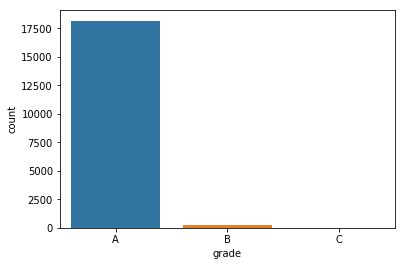

In [9]:
sns.countplot(x='grade',data=df_inspections);

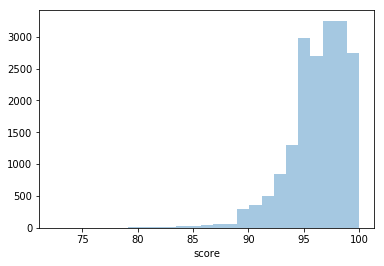

In [10]:
sns.distplot(df_inspections['score'], bins=25, kde=False);

From the graphs above we can observe that the vast majority of restaurants in our dataset are in A range, with the median being around 95 (also worth noting that the scores are $\textbf{not normally distributed}$). The scores being so high and generally close together is rather discouraging for analysis, since it is harder to investigate factors that impact scores when all of the scores are so similar. For the same reason, the letter grades are even less informative, since virtually every restaurant has an A.

Therefore, let's examine the other metrics for health/safety conditions: the number of critical/non-critical violations

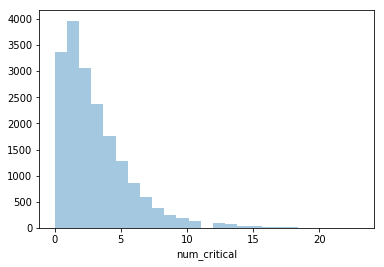

In [11]:
sns.distplot(df_inspections['num_critical'], bins=25, kde=False);

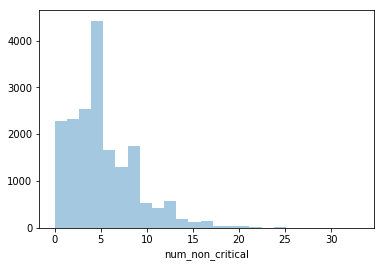

In [12]:
sns.distplot(df_inspections['num_non_critical'], bins=25, kde=False);

These histograms show that the number of violations follow a similar (though inverted) pattern, with most of the inspections falling within a lower range of violations (they are also not normally distrubuted). Note that the distribution of number of critical violations matches the distribution of scores more closely, which is expected since the critical violations have a higher impact on the score in the North Carolina system.

### Scores and number of violations per city

Having obtained a general idea of the distribution of scores in the dataset overall, we can start looking at how those numbers change based on the location of the inspected restaurant. We start that analysis by examining patterns when grouping restaurants at the city level.

In [13]:
by_city = df_inspections.groupby('city').mean()
print("Average score of city with highest score is: %f" %by_city['score'].max())
print("Average score of city with lowest score is: %f" %by_city['score'].min())
print("Average score per city: ")
by_city['score']

Average score of city with highest score is 98.250000
Average score of city with lowest score is 94.750000
Average score per city: 


city
angier           94.750000
apex             96.305868
cary             96.353045
clayton          97.111111
creedmoor        98.250000
fuquay-varina    95.031757
garner           97.096661
holly springs    95.601253
knightdale       96.453202
morrisville      95.686340
new hill         95.277778
raleigh          96.252911
rolesville       96.795620
wake forest      96.420154
wendell          96.976316
willow spring    95.659091
zebulon          96.482527
Name: score, dtype: float64

In [14]:
print("Max average number of critical violations is: %f" %by_city['num_critical'].max())
print("Min average number of critical violations is: %f" %by_city['num_critical'].min())
print("Average number of critical violations per city: ")
by_city['num_critical']

Max average number of critical violations is 6.000000
Min average number of critical violations is 0.500000
Average number of critical violations per city 


city
angier           6.000000
apex             2.997503
cary             3.188666
clayton          1.555556
creedmoor        0.500000
fuquay-varina    4.231081
garner           2.356766
holly springs    3.665971
knightdale       2.413793
morrisville      3.530504
new hill         3.777778
raleigh          2.674787
rolesville       2.124088
wake forest      2.309471
wendell          2.200000
willow spring    3.272727
zebulon          2.395161
Name: num_critical, dtype: float64

While the average score per city table information did not show much variability, with the range of averages per city being less than 4 points (out of 100), the average number of critical violations table showed greater variation, suggesting that there are differences in the overall sanitary conditions of restaurants in each city. For example, restaurants in Angier have on average 12 times more critical violations than restaraunts in Creedmoor, a significant difference. 

However, closer examination of the each of these cities, as shown below, reveals that they each have a very small number of observations, so it's mathematically more likely that they would have outlier values and they do not tell us much about the relationship we investigating.

In [15]:
print("Number of observations in Angier: %d" %df_inspections.loc[df_inspections['city'] == 'angier'].shape[0])

Number of observations in Angier: 6


In [16]:
print("Number of observations in Creedmoor: %d" %df_inspections.loc[df_inspections['city'] == 'creedmoor'].shape[0])

Number of observations in Creedmoor: 2


Given the above realization, it is possible that the variability in number of critical violations could have been simply due to outliers. To verify this possibility, we can remove cities with too few (less than 100) observations from the dataset, then check the result for the remaining ones.

In [24]:
# First get the count for each city and determine cities to drop
by_city_count = df_inspections.groupby('city').count()['score']
drop_city = []
for key in by_city_count.keys():
    if by_city_count[key] < 100:
        drop_city.append(key)

# Then use list to drop from the dataframe
df_inspections = df_inspections[~df_inspections['city'].isin(drop_city)]

# Repeat previous procedure
by_city = df_inspections.groupby('city').mean()
print("Max average number of critical violations is: %f" %by_city['num_critical'].max())
print("Min average number of critical violations is: %f" %by_city['num_critical'].min())
print("Average number of critical violations per city: ")
by_city['num_critical']

Max average number of critical violations is 4.231081
Min average number of critical violations is 2.124088
Average number of critical violations per city 


city
apex             2.997503
cary             3.188666
fuquay-varina    4.231081
garner           2.356766
holly springs    3.665971
knightdale       2.413793
morrisville      3.530504
raleigh          2.674787
rolesville       2.124088
wake forest      2.309471
wendell          2.200000
zebulon          2.395161
Name: num_critical, dtype: float64

## TODO - Possibly revisit this conclusion

Removing the outliers really narrowed the range of average number of critical violations (from 5.5 to about 1.9), and even amongst the remaining cities there is still a considerable disparity in number of observations, potentially compromising the credibility of the result.

Therefore, given the analyses abbove the data available $\textbf{does not demonstrate any significant relationship between the city a restaurant in North Carolina is located in and its overall sanitary conditions}$

### Scores and number of violations per Zip code

Not sure if it's worth keeping this section... conclusion will be basically the same. Minimal variabitliy with behavior explained by outliers (IS THIS EVEN TRUE???)

In [44]:
by_zip = df_inspections.groupby('zip').mean()
print(by_zip['score'].max())
print(by_zip['score'].min())
print(by_zip['num_critical'].max())
print(by_zip['num_critical'].min())
by_zip['num_critical']
df_inspections.groupby('zip').count()

98.33333333333333
93.5
7.666666666666667
0.5


,hsisid,city,score,grade,num_critical,num_non_critical,x,y,geocodestatus
zip,,,,,,,,,
27502,659,659,659,659,659,659,659,659,659
27511,1339,1339,1339,1339,1339,1339,1339,1339,1339
27512,18,18,18,18,18,18,18,18,18
27513,809,809,809,809,809,809,809,809,809
27518,344,344,344,344,344,344,344,344,344
27519,347,347,347,347,347,347,347,347,347
27520,17,17,17,17,17,17,17,17,17
27523,73,73,73,73,73,73,73,73,73
27526,694,694,694,694,694,694,694,694,694


In [46]:
# First get the count for each city and determine cities to drop
by_zip_count = df_inspections.groupby('zip').count()['score']
drop_zip = []
for key in by_zip_count.keys():
    if by_zip_count[key] < 100:
        drop_zip.append(key)

# Then use list to drop from the dataframe
df_temp = df_inspections[~df_inspections['zip'].isin(drop_zip)]

# Repeat previous procedure
by_zip = df_temp.groupby('zip').mean()
print("Max average number of critical violations is: %f" %by_zip['num_critical'].max())
print("Min average number of critical violations is: %f" %by_zip['num_critical'].min())
print("Average number of critical violations per city: ")
by_city['num_critical']

Max average number of critical violations is: 4.368356
Min average number of critical violations is: 1.707692
Average number of critical violations per city: 


zip
27502    2.972686
27511    2.910381
27513    4.368356
27518    1.924419
27519    2.772334
27526    4.299712
27529    2.395869
27539    3.141892
27540    3.657267
27545    2.445545
27560    3.561141
27571    2.124088
27587    2.307443
27591    2.186528
27597    2.401180
27601    2.766055
27603    3.225263
27604    3.017045
27605    2.743827
27606    1.928115
27607    2.679268
27608    2.261538
27609    2.904198
27610    2.535211
27612    3.394265
27613    2.638298
27614    1.748963
27615    2.103155
27616    2.116410
27617    3.779703
27695    1.707692
Name: num_critical, dtype: float64

### Predicting score and number of violations based on coordinate location

One last way to assess the impact of location in restaurants' sanitary conditions is to look at similarity in results among restaurants that are close together based on their actual geographical proxmity, using the X and Y coordinates from the dataset. To do so, we can use K-Nearest Neighbor regression models to predict restaraunt scores/number of critical violations, splitting the data into train and test, then use MSe on the test predictions to assess the efficiency of the models.

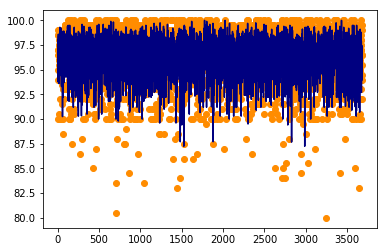

5.261377351472517


In [104]:
# First shuffle dataframe in case observations are in some location-related order
df_inspections_shuffled = df_inspections.sample(frac=1)

# Extract relevant columns
X_coords = df_inspections_shuffled['x'].tolist()
Y_coords = df_inspections_shuffled['y'].tolist()
zip_codes = df_inspections_shuffled['zip'].tolist()
scores = df_inspections_shuffled['score'].tolist()
num_critical = df_inspections_shuffled['num_critical'].tolist()

# 80/20 split for train and test
train_len = int(0.8 * len(X_coords))
X_train = X_coords[:train_len]
X_test = X_coords[train_len:]
Y_train = Y_coords[:train_len]
Y_test = Y_coords[train_len:]
zip_train = zip_codes[:train_len]
zip_test = zip_codes[train_len:]
train_score = scores[:train_len]
test_score = scores[train_len:]
train_num_critical = num_critical[:train_len]
test_num_critical = num_critical[train_len:]

# Separating into test and train array
train_array = []
for i in range(0,len(X_train)):
    train_array.append([X_train[i],Y_train[i]])
    
test_array = []
for i in range(0,len(X_test)):
    test_array.append([X_test[i],Y_test[i]])
    
# Training, predicting, and evaluating results
KNN = KNeighborsRegressor(weights='distance')
KNN.fit(train_array,train_score)
score_prediction = KNN.predict(test_array)

X = np.arange(0,len(test_score))
plt.scatter(X, test_score, color='darkorange', label='data')
plt.plot(X, score_prediction, color='navy', label='prediction')
plt.axis('tight')

plt.show()

print(mean_squared_error(test_score,score_prediction))









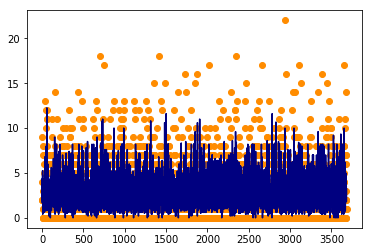

7.024498627052084


In [105]:
KNN = KNeighborsRegressor(weights='distance')
KNN.fit(train_array,train_num_critical)
num_critical_prediction = KNN.predict(test_array)

plt.scatter(X, test_num_critical, color='darkorange', label='data')
plt.plot(X, num_critical_prediction, color='navy', label='prediction')
plt.axis('tight')

plt.show()


print(mean_squared_error(test_num_critical,num_critical_prediction))

To help quantify the significance of the above data, we can compare to the performance of a model that randomly guesses a number within the range that most of the data lies (94-100 for score and 0-10 for number of critical violations)

In [83]:
random_scores = []
for i in range(0,len(test_score)):
    random_scores.append(random.randint(94,100))
    
print(mean_squared_error(test_score,random_scores))

12.15221226927253


In [85]:
random_num_critical = []
for i in range(0,len(test_num_critical)):
    random_num_critical.append(random.randint(0,10))
    
print(mean_squared_error(test_num_critical,random_num_critical))

21.83469055374593


Better than random... what now?

### Investigating impact of socio-economic indicators

Some introduction here

In [113]:
df_joined = df_inspections.set_index('zip').join(other=df_zipcodes.set_index('zip'))
df_joined.head()

,hsisid,city,score,grade,num_critical,num_non_critical,x,y,geocodestatus,median_household_income_dollars,per_capita_income_dollars,percent_families_below_poverty_line
zip,,,,,,,,,,,,
27502,4092015179,apex,99.0,A,6,6,-78.840340,35.717045,M,95857.0,36763.0,3.4
27502,4092050026,apex,96.5,A,5,7,-78.874646,35.724399,M,95857.0,36763.0,3.4
27502,4092020999,apex,97.0,A,8,3,-78.877707,35.759649,M,95857.0,36763.0,3.4
27502,4092300175,apex,98.0,A,7,4,-78.877707,35.759649,M,95857.0,36763.0,3.4
27502,4092012834,apex,95.0,A,11,7,-78.840629,35.715928,M,95857.0,36763.0,3.4


# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*